# Calculate and Plot Phasor Plots

## Set data path

In [21]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import napari
from PhasorPy import phasor, phasor_plot, rgb_coloring, phasor_circle, histogram_filtering,  ndmedian
from FLIM_phasor import *
from readPTU_FLIM import PTUreader
from matplotlib import colors
import pandas as pd
import napari
from skimage import filters, morphology, measure
from scipy.ndimage import convolve
from skimage import segmentation

In [22]:
# data_path = "C:/Users/mazo260d/Desktop/Conni_BiA_PoL/copied_for_Marcelo/single_image/raw_FLIM_data/single_FLIM_image.ptu"
data_path = "C:/Users/cblei/Desktop/miniSabb_local/FLIM_file_formats/single_FLIM_image.ptu"

In [23]:
data_path = Path(data_path)
print(data_path)

C:\Users\cblei\Desktop\miniSabb_local\FLIM_file_formats\single_FLIM_image.ptu


## Open ptu file

In [24]:
ptu_file = PTUreader(data_path, print_header_data = False)

TCSPC Hardware: PicoHarpT3
Raw Data has been Read!



## Get FLIM data

In [25]:
flim_data_stack, intensity_image = ptu_file.get_flim_data_stack()

## Format data

Re-arange axes to have (x,y) by the end

In [26]:
flim_data_stack_for_napari = np.moveaxis(flim_data_stack, [0, 1], [-2, -1])

Get only first channel (the second channel for this image is empty)

In [27]:
flim_data_stack_for_napari = flim_data_stack_for_napari[0, :, :, :]

In [28]:
flim_data_stack_for_napari.shape

(270, 512, 512)

## Plot FLIM

In [29]:
ptu_file._print_ptu_head()

Head ID                        Value   
File_GUID                      40      
File_CreatingTime              13301658052.442
$StartedByRemoteInterface      1       
Measurement_SubMode            3       
File_Comment                           
TTResult_StopReason            1       
Fast_Load_End                  0       
CreatorSW_Name                 SymPhoTime 64
CreatorSW_Version              1.6     
CreatorSW_SVNBuild             3224    
CreatorSW_Modules              0       
$ReqHdr_RecordVersion          16777728
$ReqHdr_MeasurementType        1       
$ReqHdr_PixelNumber_X          512     
$ReqHdr_PixelNumber_Y          512     
$ReqHdr_ScanningPattern        0       
$ReqHdr_SpatialResolution      0.07035765166
$Filename                      single_FLIM_image
$Comment                               
$Groupname                     single_FLIM_image
ImgHdr_Dimensions              3       
ImgHdr_Ident                   3       
ImgHdr_PixX                    512     
ImgHd

Read Laser Frequency from metadata

In [30]:
laser_frequency = ptu_file.head['TTResult_SyncRate'] *1E-6 #MHz
print('laser repetition rate: ', laser_frequency, ' MHz')

laser repetition rate:  39.01  MHz


Create time array

In [31]:
time_array = create_time_array(laser_frequency, n_points = flim_data_stack_for_napari.shape[0])
time_step = time_array[1]
print('time bins are about ', round(time_step*1000, 1), ' ns')

time bins are about  94.9  ns


Estimate starting point

In [32]:
heights, bin_edges = np.histogram(np.ravel(np.argmax(flim_data_stack_for_napari, axis=0) * time_step), bins=time_array)
start_index = np.argmax(heights[1:]) + 1

Plot image average intensity over time

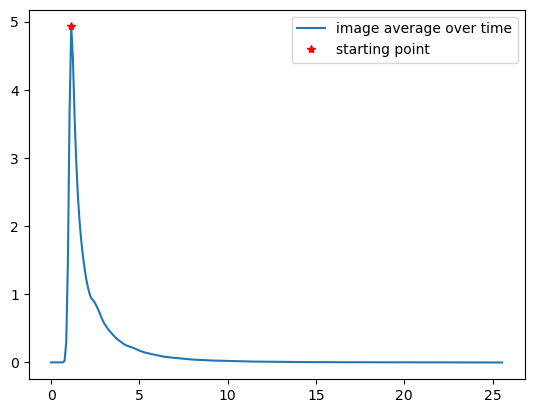

In [33]:
mean_intensity = np.mean(flim_data_stack_for_napari, axis=(1,2))
plt.plot(time_array, mean_intensity, label = 'image average over time')

time_mask = time_array >= time_array[start_index]
plt.plot(time_array[start_index], mean_intensity[start_index], 'r*', label = 'starting point')
plt.legend()

## Phasor Plot

### Reference tau lines

### Definition of lifetimes

In [34]:
tau_list = [0.5, 1, 2, 3, 4, 5, 6] #ns

## Display in napari

In [81]:
viewer = napari.Viewer()
viewer.add_image(flim_data_stack_for_napari)

<Image layer 'flim_data_stack_for_napari' at 0x22ca5727af0>

### Apply threshold 
Apply threshold over the summed intensity image

In [82]:
# intensity_image2 = np.mean(flim_data, axis=0)
threshold = filters.threshold_otsu(intensity_image)

# threshold = 43   # in exported images from LAS X

space_mask = intensity_image > threshold
print('threshold: ', threshold)

threshold:  91


In [83]:
flim_image = flim_data_stack_for_napari

## Calculate phasors

In [86]:
def make_flim_label_layer(image, threshold = 0, apply_median = False):
  
    if apply_median:
        
        window_size = 3
        footprint = morphology.square(3)
        flim_image = np.zeros_like(flim_data_stack_for_napari)
        for i in range(flim_data_stack_for_napari.shape[0]):
            flim_image[i] = filters.median(flim_data_stack_for_napari[i])
    
    else:
        image_filtered = image
        
    space_mask = np.sum(image_filtered, axis=0) > threshold
    
    g, s = get_phasor_components(image_filtered, harmonic = 1)
    print(g.shape)
    g = g[space_mask]
    s = s[space_mask]
    
    label_image = np.arange(image.shape[-2]*image.shape[-1]).reshape(image.shape[1:3]) + 1
    
    label_image = np.where(space_mask == False, 0, label_image)
    
    label_image = segmentation.relabel_sequential(label_image)[0]
    
    phasor_components = {'label': label_image[space_mask], 'G': g, 'S': s}
    table = pd.DataFrame(phasor_components)
    
    return label_image, table

In [87]:
labels_layer, feature_table = make_flim_label_layer(flim_image[time_mask], threshold=filters.threshold_otsu(flim_image[time_mask]))
viewer.add_labels(labels_layer, features = feature_table)

(512, 512)
[    1     2     3 ... 95950 95951 95952]


<Labels layer 'labels_layer' at 0x22cb06f53a0>

Selected labels layer: labels_layer
Selected measurements: ['G', 'S']
Selected clustering method: HDBSCAN
HDBSCAN predictions finished.
Selected labels layer: labels_layer
Selected measurements: ['G', 'S']
Selected clustering method: KMeans
KMEANS predictions finished.


Working up to here

In [51]:
arraz = np.arange(4).reshape(2,2, order = 'F') + 1
arraz

array([[1, 3],
       [2, 4]])

In [42]:
space_mask2 = np.array([[True, False], [False, True]])
space_mask2

array([[ True, False],
       [False,  True]])

In [43]:
arraz[space_mask2]

array([1, 4])

In [45]:
label_image_filtered = np.where(space_mask2 == False, 0, arraz)

In [37]:
arraz[-2:]

(6, 9)

## Stop here

## Open clusters plotter

In [46]:
from napari.utils import nbscreenshot

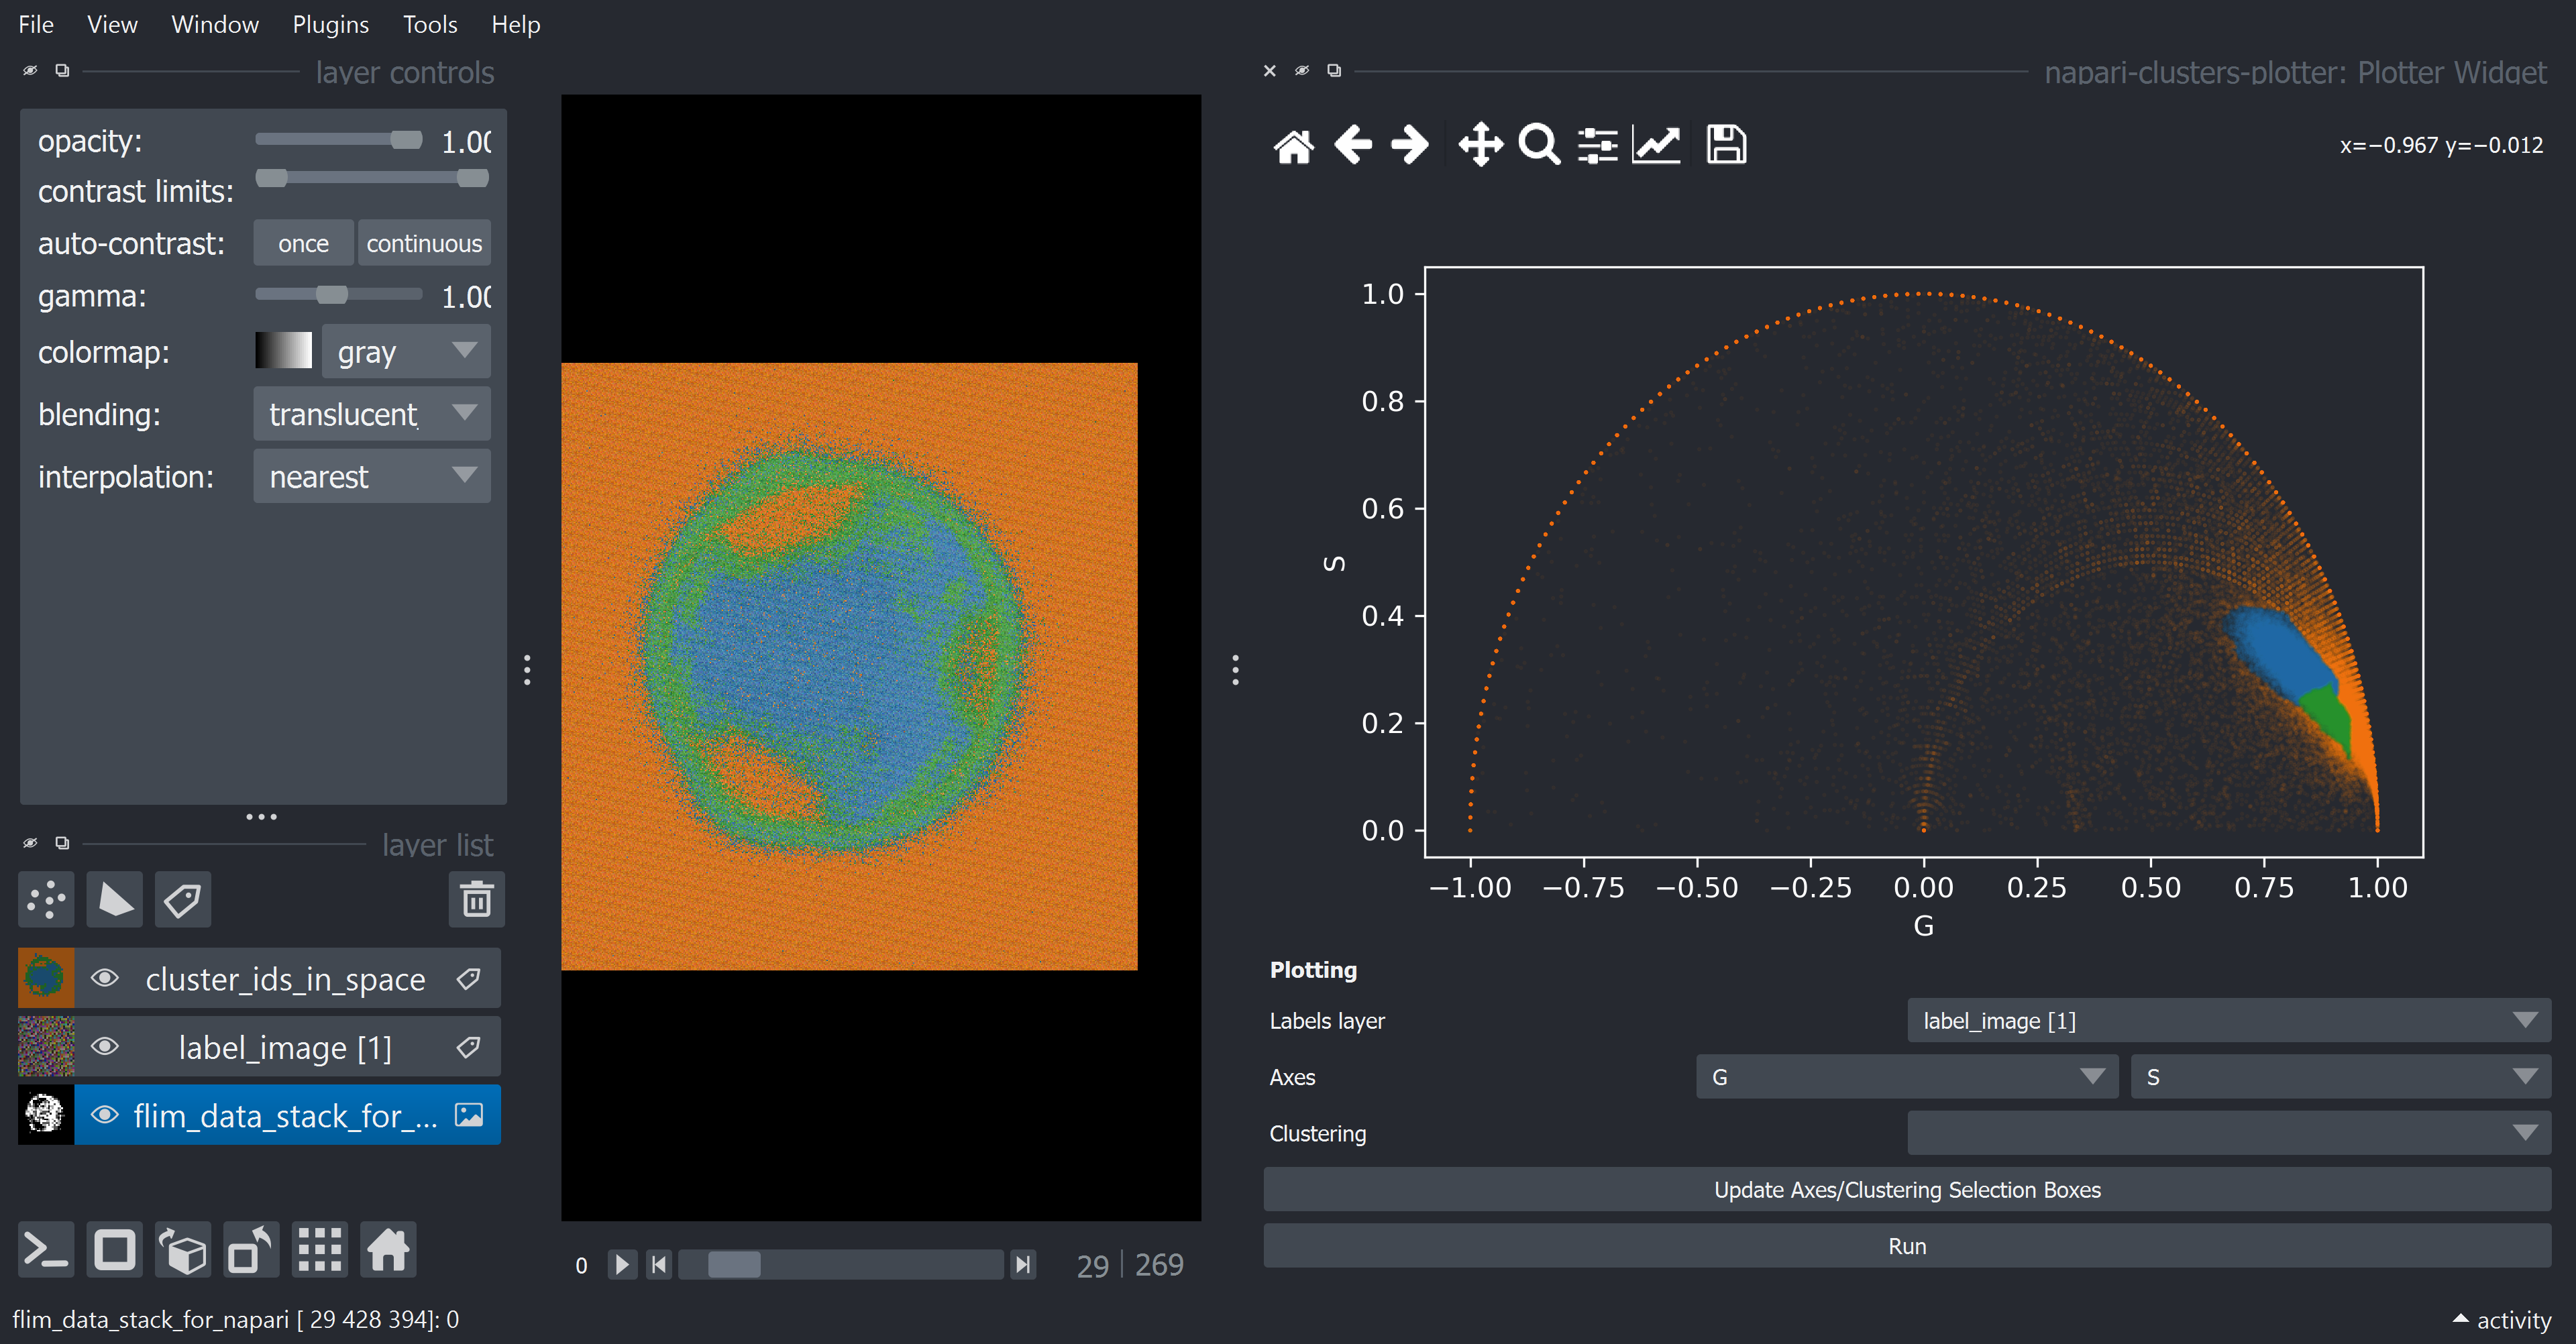

In [47]:
nbscreenshot(viewer)